In [1]:
import os, sys, shutil, pathlib, json, random, time
from tqdm import tqdm
from pathlib import Path

print("Python:", sys.version)

Python: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]


In [2]:
import torch
from ultralytics import YOLO

print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
device = 0 if torch.cuda.is_available() else "cpu"
device

Torch: 2.8.0+cu128 | CUDA available: True


0

In [3]:
data_dir = Path("../datasets/Roboflow")  # <-- change this
assert (data_dir / "data.yaml").exists(), "data.yaml not found—check your path."
print((data_dir / "data.yaml").read_text()[:500])

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['license-plate']

roboflow:
  workspace: car-plate-fcnrs
  project: sg-license-plate-yqedo
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/car-plate-fcnrs/sg-license-plate-yqedo/dataset/2


## Training

In [ ]:
# Paths
DATA_YAML = (data_dir / "data.yaml")      # <- update to your dataset path
PROJECT   = "runs_sg"                    # custom project folder (avoids clobbering default runs/)
RUN_NAME  = "yolo11_sg_plate"            # run name; resume uses this

# Model & training hyperparameters
BASE_MODEL   = "yolo11n.pt"              # yolo11n/s/m/l; pick 'm' or 'l' if you have more VRAM
TOTAL_EPOCHS = 60
IMGSZ        = 960                        # 1280 if you have headroom, 640 if OOM
BATCH        = 8                          # lower to 4/2 if OOM
ACCUMULATE   = 2                          # simulates larger effective batch (BATCH * ACCUMULATE)
DEVICE       = 0 if torch.cuda.is_available() else "cpu"

# Common augment & scheduler settings (good recall)
TRAIN_KW = dict(
    data=DATA_YAML,
    imgsz=IMGSZ,
    batch=BATCH,
    nbs=256,
    device=DEVICE,
    epochs=1,                 # <- we run one epoch per loop
    cos_lr=True,
    lr0=0.01,
    warmup_epochs=3,
    patience=20,
    mosaic=1.0, mixup=0.2, copy_paste=0.2, close_mosaic=10,
    hsv_h=0.015, hsv_s=0.6, hsv_v=0.6,
    translate=0.10, scale=0.70,
    degrees=0.0, shear=0.0, perspective=0.0,
    workers=2,
    cache=False,
    project=PROJECT,
    name=RUN_NAME,
)

In [ ]:
import time
from pathlib import Path
from tqdm.auto import tqdm
from ultralytics import YOLO

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Your original TRAIN_KW, but ensure these defaults:
TRAIN_KW.setdefault("project", PROJECT)
TRAIN_KW.setdefault("name", RUN_NAME)
TRAIN_KW.setdefault("exist_ok", True)   # prevent yolo11_sg_plate2, ...3, etc.
TRAIN_KW.setdefault("save", True)
TRAIN_KW["epochs"] = 1                  # IMPORTANT: one epoch per outer loop

# First epoch: start from a base checkpoint (auto-downloads)
model = YOLO(BASE_MODEL)

# Set up real-time plotting
plt.ion()
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('Real-time Training Metrics', fontsize=14)

t0 = time.time()
save_dir = None  # will be discovered after first train()

for ep in tqdm(range(2, TOTAL_EPOCHS + 1), desc="Training (epochs)", unit="epoch"):
    if ep == 1:
        results = model.train(**TRAIN_KW)  # start fresh
        # Capture the actual directory Ultralytics used
        save_dir = Path(getattr(model.trainer, "save_dir"))
    else:
        results = model.train(**TRAIN_KW)
        if save_dir is None:
            save_dir = Path(getattr(model.trainer, "save_dir"))
        # Prefer the known save_dir; fallback to newest last.pt if not found
        last_ckpt = save_dir / "weights" / "last.pt"
        if not last_ckpt.exists():
            # Fallback: find newest last.pt anywhere under PROJECT
            candidates = sorted(
                Path(PROJECT).rglob("weights/last.pt"),
                key=lambda p: p.stat().st_mtime,
                reverse=True,
            )
            if not candidates:
                raise FileNotFoundError(f"No checkpoints found under {PROJECT}")
            last_ckpt = candidates[0]
            save_dir = last_ckpt.parent.parent  # sync to the actual run folder
        model = YOLO(str(last_ckpt))
        results = model.train(resume=False, **TRAIN_KW)  # resume keeps hparams

    # Read the latest metrics from the actual run folder
    results_csv = save_dir / "results.csv"
    if results_csv.exists():
        try:
            df = pd.read_csv(results_csv)
            df.columns = df.columns.str.strip()

            for ax in axes.flat:
                ax.clear()

            # Box Loss
            if 'train/box_loss' in df.columns:
                axes[0, 0].plot(df.index + 1, df['train/box_loss'], 'b-', label='Train', alpha=0.8)
                if 'val/box_loss' in df.columns:
                    axes[0, 0].plot(df.index + 1, df['val/box_loss'], 'r-', label='Val', alpha=0.8)
                axes[0, 0].set_title('Box Loss'); axes[0, 0].set_xlabel('Epoch'); axes[0, 0].set_ylabel('Loss'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

            # Classification Loss
            if 'train/cls_loss' in df.columns:
                axes[0, 1].plot(df.index + 1, df['train/cls_loss'], 'b-', label='Train', alpha=0.8)
                if 'val/cls_loss' in df.columns:
                    axes[0, 1].plot(df.index + 1, df['val/cls_loss'], 'r-', label='Val', alpha=0.8)
                axes[0, 1].set_title('Classification Loss'); axes[0, 1].set_xlabel('Epoch'); axes[0, 1].set_ylabel('Loss'); axes[0, 1].legend(); axes[0, 1].grid(True, alpha=0.3)

            # mAP
            if 'metrics/mAP50(B)' in df.columns:
                axes[1, 0].plot(df.index + 1, df['metrics/mAP50(B)'], 'g-', label='mAP@0.5', alpha=0.8)
                if 'metrics/mAP50-95(B)' in df.columns:
                    axes[1, 0].plot(df.index + 1, df['metrics/mAP50-95(B)'], 'orange', label='mAP@0.5:0.95', alpha=0.8)
                axes[1, 0].set_title('Mean Average Precision'); axes[1, 0].set_xlabel('Epoch'); axes[1, 0].set_ylabel('mAP'); axes[1, 0].legend(); axes[1, 0].grid(True, alpha=0.3)

            # DFL or LR
            if 'train/dfl_loss' in df.columns:
                axes[1, 1].plot(df.index + 1, df['train/dfl_loss'], 'purple', label='Train DFL', alpha=0.8)
                if 'val/dfl_loss' in df.columns:
                    axes[1, 1].plot(df.index + 1, df['val/dfl_loss'], 'orange', label='Val DFL', alpha=0.8)
                axes[1, 1].set_title('Distribution Focal Loss'); axes[1, 1].set_xlabel('Epoch'); axes[1, 1].set_ylabel('Loss'); axes[1, 1].legend(); axes[1, 1].grid(True, alpha=0.3)
            elif 'lr/pg0' in df.columns:
                axes[1, 1].plot(df.index + 1, df['lr/pg0'], 'purple', label='Learning Rate', alpha=0.8)
                axes[1, 1].set_title('Learning Rate'); axes[1, 1].set_xlabel('Epoch'); axes[1, 1].set_ylabel('LR'); axes[1, 1].legend(); axes[1, 1].grid(True, alpha=0.3)

            plt.tight_layout(); plt.draw(); plt.pause(0.01)

            # Print current epoch metrics
            if len(df) > 0:
                latest = df.iloc[-1]
                print(f"\nEpoch {ep} metrics:")
                if 'train/box_loss' in df.columns:
                    print(f"  Box Loss: {latest.get('train/box_loss', np.nan):.4f}")
                if 'train/cls_loss' in df.columns:
                    print(f"  Cls Loss: {latest.get('train/cls_loss', np.nan):.4f}")
                if 'metrics/mAP50(B)' in df.columns:
                    print(f"  mAP@0.5: {latest.get('metrics/mAP50(B)', np.nan):.4f}")

        except Exception as e:
            print(f"Could not update plots: {e}")

plt.ioff()
elapsed = time.time() - t0
print(f"\nDone: {TOTAL_EPOCHS} epochs in {elapsed/60:.1f} min")

best_pt = save_dir / "weights" / "best.pt"
print("Best weights:", best_pt if best_pt.exists() else "(not found yet)")

Training (epochs):   0%|          | 0/4 [00:00<?, ?epoch/s]

Ultralytics 8.3.189  Python-3.13.5 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Laptop GPU, 8151MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=..\datasets\Roboflow\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6, hsv_v=0.6, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11_sg_plate, nbs=256, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots

<Figure size 640x480 with 0 Axes>

Training (epochs):  25%|██▌       | 1/4 [03:44<11:12, 224.28s/epoch]


Epoch 2 metrics:
  Box Loss: 1.2475
  Cls Loss: 1.4830
  mAP@0.5: 0.9561
Ultralytics 8.3.189  Python-3.13.5 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Laptop GPU, 8151MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=..\datasets\Roboflow\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6, hsv_v=0.6, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=runs_sg\yolo11_sg_plate\weights\last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11_sg_plate, nbs=256, nms=Fa

<Figure size 640x480 with 0 Axes>

Training (epochs):  50%|█████     | 2/4 [07:25<07:25, 222.55s/epoch]


Epoch 3 metrics:
  Box Loss: 1.1198
  Cls Loss: 0.9113
  mAP@0.5: 0.9614
Ultralytics 8.3.189  Python-3.13.5 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Laptop GPU, 8151MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=..\datasets\Roboflow\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6, hsv_v=0.6, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=runs_sg\yolo11_sg_plate\weights\last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11_sg_plate, nbs=256, nms=Fa

<Figure size 640x480 with 0 Axes>

Training (epochs):  75%|███████▌  | 3/4 [11:11<03:44, 224.01s/epoch]


Epoch 4 metrics:
  Box Loss: 1.0362
  Cls Loss: 0.7349
  mAP@0.5: 0.9637
Ultralytics 8.3.189  Python-3.13.5 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Laptop GPU, 8151MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=..\datasets\Roboflow\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6, hsv_v=0.6, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=runs_sg\yolo11_sg_plate\weights\last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11_sg_plate, nbs=256, nms=Fa

<Figure size 640x480 with 0 Axes>

Training (epochs): 100%|██████████| 4/4 [14:55<00:00, 223.93s/epoch]


Epoch 5 metrics:
  Box Loss: 0.9851
  Cls Loss: 0.6615
  mAP@0.5: 0.9027

Done: 5 epochs in 14.9 min
Best weights: runs_sg\yolo11_sg_plate\weights\best.pt


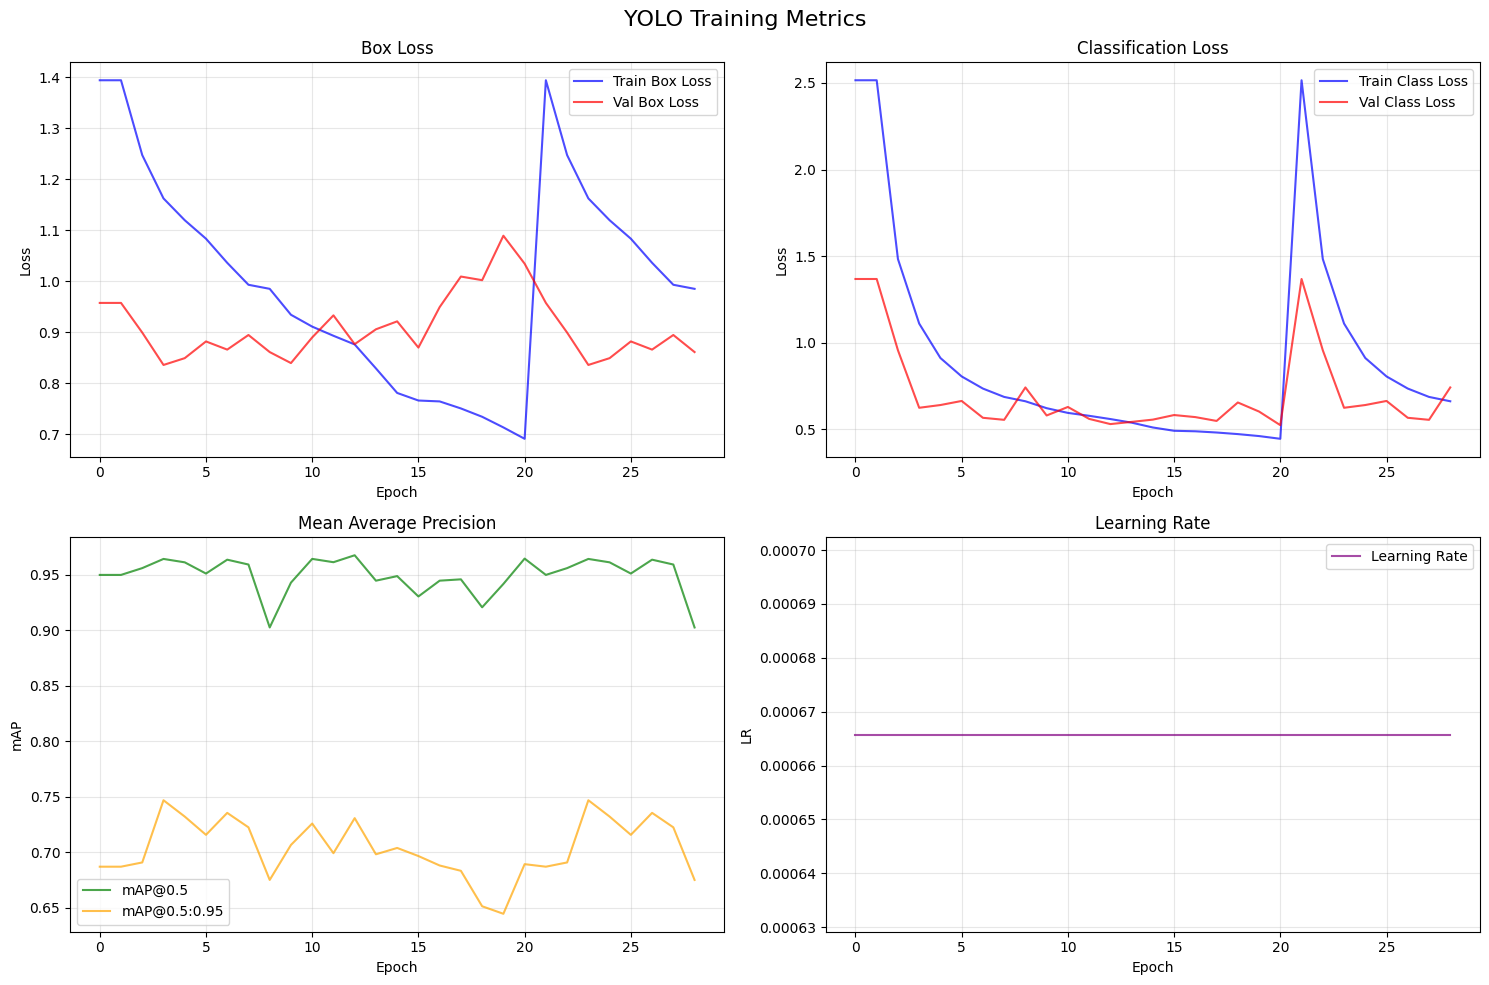


Training Summary:
Total epochs completed: 29
Best mAP@0.5: 0.9677 at epoch 13
Best mAP@0.5:0.95: 0.7470 at epoch 4

Available metrics columns:
  - lr/pg0
  - lr/pg1
  - lr/pg2
  - metrics/mAP50(B)
  - metrics/mAP50-95(B)
  - metrics/precision(B)
  - metrics/recall(B)
  - train/box_loss
  - train/cls_loss
  - train/dfl_loss
  - val/box_loss
  - val/cls_loss
  - val/dfl_loss


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Load training results
results_csv = Path(PROJECT) / RUN_NAME / "results.csv"

if results_csv.exists():
    # Read the results CSV
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()  # Remove any whitespace from column names
    
    # Create subplots for different metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('YOLO Training Metrics', fontsize=16)
    
    # Box Loss
    if 'train/box_loss' in df.columns:
        axes[0, 0].plot(df.index, df['train/box_loss'], 'b-', label='Train Box Loss', alpha=0.7)
        if 'val/box_loss' in df.columns:
            axes[0, 0].plot(df.index, df['val/box_loss'], 'r-', label='Val Box Loss', alpha=0.7)
        axes[0, 0].set_title('Box Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    
    # Class Loss
    if 'train/cls_loss' in df.columns:
        axes[0, 1].plot(df.index, df['train/cls_loss'], 'b-', label='Train Class Loss', alpha=0.7)
        if 'val/cls_loss' in df.columns:
            axes[0, 1].plot(df.index, df['val/cls_loss'], 'r-', label='Val Class Loss', alpha=0.7)
        axes[0, 1].set_title('Classification Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # mAP metrics
    if 'metrics/mAP50(B)' in df.columns:
        axes[1, 0].plot(df.index, df['metrics/mAP50(B)'], 'g-', label='mAP@0.5', alpha=0.7)
        if 'metrics/mAP50-95(B)' in df.columns:
            axes[1, 0].plot(df.index, df['metrics/mAP50-95(B)'], 'orange', label='mAP@0.5:0.95', alpha=0.7)
        axes[1, 0].set_title('Mean Average Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('mAP')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Learning Rate and other metrics
    if 'lr/pg0' in df.columns:
        axes[1, 1].plot(df.index, df['lr/pg0'], 'purple', label='Learning Rate', alpha=0.7)
        axes[1, 1].set_title('Learning Rate')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('LR')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    elif 'train/dfl_loss' in df.columns:
        axes[1, 1].plot(df.index, df['train/dfl_loss'], 'purple', label='Train DFL Loss', alpha=0.7)
        if 'val/dfl_loss' in df.columns:
            axes[1, 1].plot(df.index, df['val/dfl_loss'], 'orange', label='Val DFL Loss', alpha=0.7)
        axes[1, 1].set_title('Distribution Focal Loss')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nTraining Summary:")
    print(f"Total epochs completed: {len(df)}")
    if 'metrics/mAP50(B)' in df.columns:
        print(f"Best mAP@0.5: {df['metrics/mAP50(B)'].max():.4f} at epoch {df['metrics/mAP50(B)'].idxmax() + 1}")
    if 'metrics/mAP50-95(B)' in df.columns:
        print(f"Best mAP@0.5:0.95: {df['metrics/mAP50-95(B)'].max():.4f} at epoch {df['metrics/mAP50-95(B)'].idxmax() + 1}")
    
    # Display available columns for reference
    print(f"\nAvailable metrics columns:")
    for col in sorted(df.columns):
        if '/' in col:  # Only show metric columns
            print(f"  - {col}")
            
else:
    print(f"Results file not found: {results_csv}")
    print("Train the model first to generate metrics.")

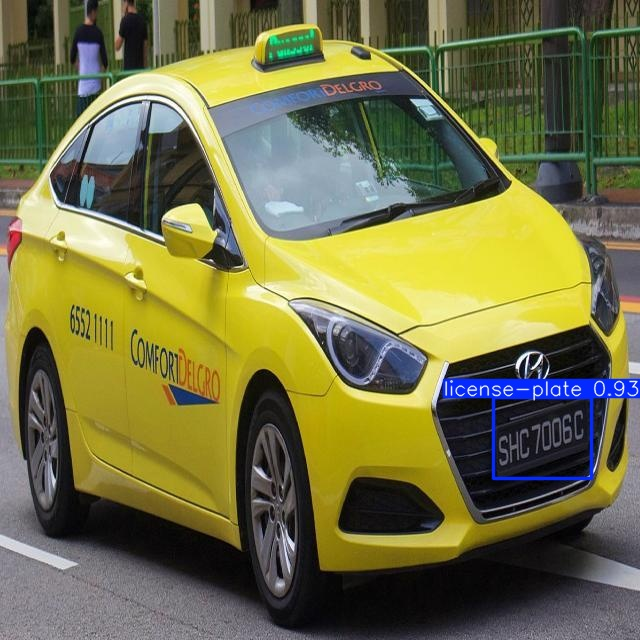

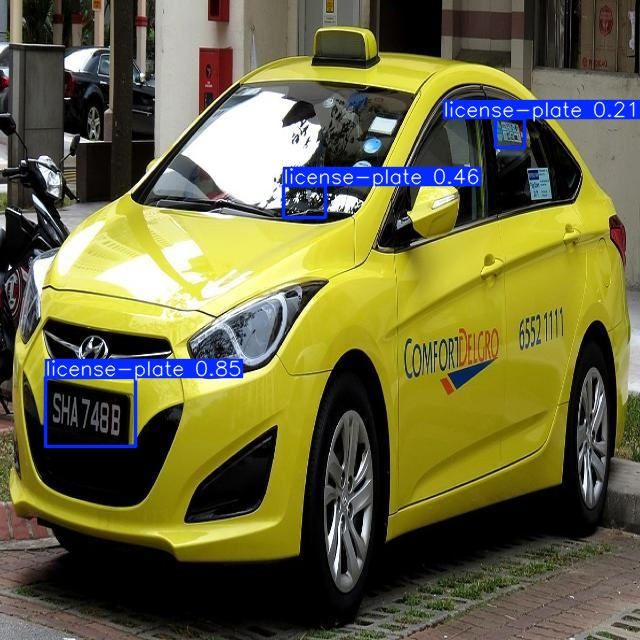

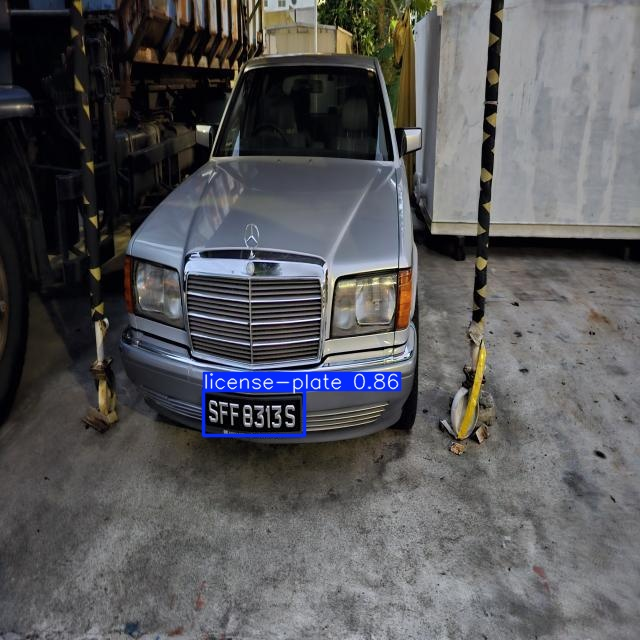

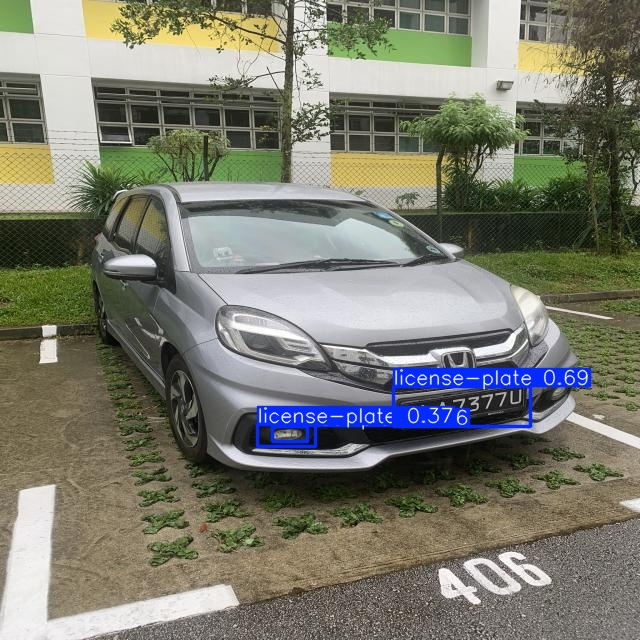

In [16]:
from IPython.display import display, Image
import glob, os

# Load the best weights just to be explicit
detector = YOLO(str(best_pt))

sample_images = sorted(glob.glob(str(data_dir / "valid" / "images" / "*")))[:8]
out_dir = Path("pred_samples"); out_dir.mkdir(exist_ok=True)

for im in sample_images:
    res = detector.predict(source=im, imgsz=IMGSZ, conf=0.2, iou=0.5, device=DEVICE, verbose=False)
    # Save a rendered image with boxes
    for r in res:
        r.save(filename=str(out_dir / f"pred_{Path(im).name}"))

# Display a couple
for im in sorted(glob.glob(str(out_dir / "pred_*")))[:4]:
    display(Image(filename=im))

# Evaluation to base model

In [23]:
IOU = 0.5
CONF = 0.4
FT_MODEL = Path("runs_sg/yolo11_sg_plate/weights/best.pt")  # the finetuned model from above

def _get(d, keys, default=0.0):
    for k in keys:
        if k in d:
            try:
                return float(d[k])
            except Exception:
                pass
    return float(default)

def eval_once(model_path, data_yaml=DATA_YAML, imgsz=IMGSZ, device=DEVICE, iou=IOU, conf=CONF):
    m = YOLO(model_path)
    r = m.val(data=data_yaml, imgsz=imgsz, device=device, iou=iou, conf=conf, plots=False, verbose=False)
    d = r.results_dict or {}
    precision = _get(d, ["metrics/precision(B)", "precision"])
    recall    = _get(d, ["metrics/recall(B)", "recall"])
    map50     = _get(d, ["metrics/mAP50(B)", "map50", "mAP50"])
    map5095   = _get(d, ["metrics/mAP50-95(B)", "map", "mAP50-95"])
    return {
        "precision@0.5": precision,
        "recall@0.5": recall,
        "miss_rate": 1.0 - recall,
        "mAP@0.5": map50,
        "mAP@0.5:0.95": map5095,
    }

def sweep_conf(model_path, confs=np.linspace(0.05, 0.5, 10), data_yaml=DATA_YAML, imgsz=IMGSZ, device=DEVICE, iou=IOU):
    m = YOLO(model_path)
    out = []
    for c in confs:
        r = m.val(data=data_yaml, imgsz=imgsz, device=device, iou=iou, conf=float(c), plots=False, verbose=False)
        d = r.results_dict or {}
        out.append({
            "conf": float(c),
            "recall@0.5": _get(d, ["metrics/recall(B)", "recall"]),
            "precision@0.5": _get(d, ["metrics/precision(B)", "precision"]),
            "mAP@0.5": _get(d, ["metrics/mAP50(B)", "map50", "mAP50"])
        })
    return pd.DataFrame(out)

MODELS = [
    ("YOLO11-base", BASE_MODEL),
    ("YOLO11-finetuned", FT_MODEL),
]


In [24]:
rows = []
for name, path in MODELS:
    metrics = eval_once(path)
    rows.append({"model": name, **metrics})
summary_df = pd.DataFrame(rows).set_index("model")
summary_df.round(4)


Ultralytics 8.3.189  Python-3.13.5 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Laptop GPU, 8151MiB)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 622.7160.3 MB/s, size: 52.4 KB)
val: Scanning C:\Computer Science\Projects\tiktok-techjam-2025\datasets\Roboflow\valid\labels.cache... 328 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 328/328 410911.5it/s 0.0s.0s
WARNING Box and segment counts should be equal, but got len(segments) = 35, len(boxes) = 341. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 21/21 7.4it/s 2.8s
                   all        328        341          0          0          0          0
Speed: 0.5ms preprocess, 6.1ms inference, 0.0ms loss, 0.6ms

,precision@0.5,recall@0.5,miss_rate,mAP@0.5,mAP@0.5:0.95
model,,,,,
YOLO11-base,0.0000,0.0000,1.0000,0.0000,0.0000
YOLO11-finetuned,0.8593,0.9179,0.0821,0.9084,0.7095


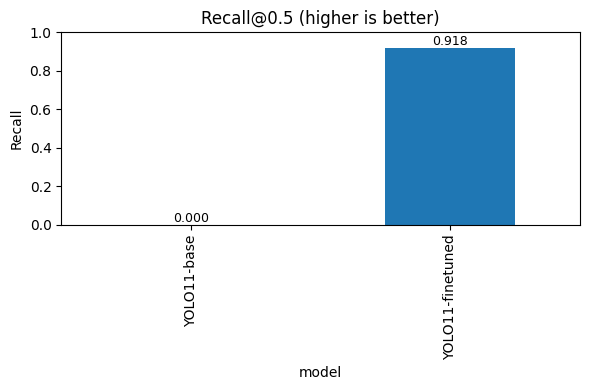

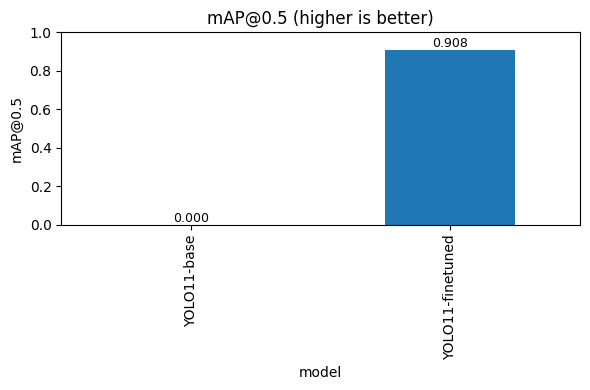

In [25]:
# Recall@0.5
ax = summary_df["recall@0.5"].plot(kind="bar", figsize=(6,4))
ax.set_title("Recall@0.5 (higher is better)")
ax.set_ylabel("Recall")
ax.set_ylim(0, 1.0)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x()+p.get_width()/2, p.get_height()), 
                ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

# mAP@0.5
ax = summary_df["mAP@0.5"].plot(kind="bar", figsize=(6,4))
ax.set_title("mAP@0.5 (higher is better)")
ax.set_ylabel("mAP@0.5")
ax.set_ylim(0, 1.0)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x()+p.get_width()/2, p.get_height()), 
                ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()


Ultralytics 8.3.189  Python-3.13.5 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Laptop GPU, 8151MiB)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 492.0111.8 MB/s, size: 43.7 KB)
val: Scanning C:\Computer Science\Projects\tiktok-techjam-2025\datasets\Roboflow\valid\labels.cache... 328 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 328/328 281796.7it/s 0.0s.0s
WARNING Box and segment counts should be equal, but got len(segments) = 35, len(boxes) = 341. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 21/21 7.1it/s 3.0s
                   all        328        341          0          0          0          0
Speed: 0.3ms preprocess, 5.7ms inference, 0.0ms loss, 1.0ms

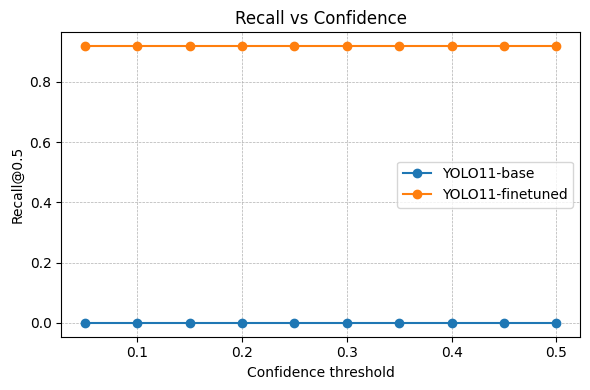

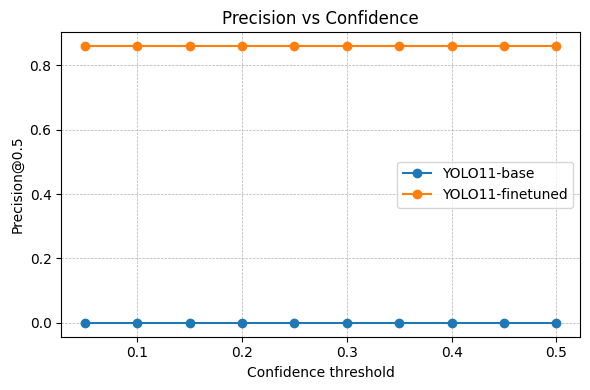

In [26]:
confs = np.linspace(0.05, 0.5, 10)

curves = {}
for name, path in MODELS:
    curves[name] = sweep_conf(path, confs=confs)

# Plot Recall vs conf
plt.figure(figsize=(6,4))
for name, df in curves.items():
    plt.plot(df["conf"], df["recall@0.5"], marker="o", label=name)
plt.xlabel("Confidence threshold")
plt.ylabel("Recall@0.5")
plt.title("Recall vs Confidence")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# (Optional) Precision vs conf
plt.figure(figsize=(6,4))
for name, df in curves.items():
    plt.plot(df["conf"], df["precision@0.5"], marker="o", label=name)
plt.xlabel("Confidence threshold")
plt.ylabel("Precision@0.5")
plt.title("Precision vs Confidence")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


,FPS@imgsz
model,
YOLO11-base,89.6
YOLO11-finetuned,84.5


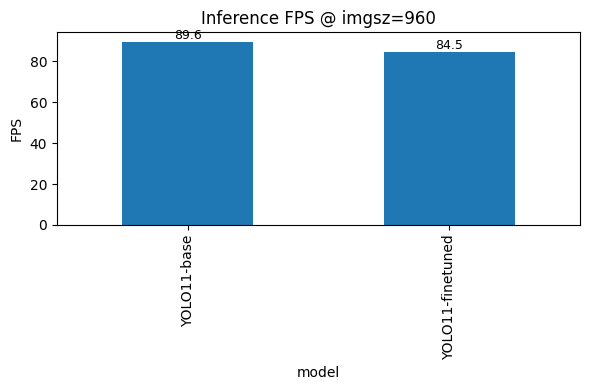

In [27]:
import time
import numpy as np

def benchmark_fps(model_path, imgsz=IMGSZ, device=DEVICE, iters=30):
    m = YOLO(model_path)
    # dummy image in RGB
    dummy = np.random.randint(0,255,(imgsz, imgsz, 3), dtype=np.uint8)
    # warmup
    for _ in range(3):
        _ = m.predict(source=dummy, imgsz=imgsz, device=device, verbose=False)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t0 = time.time()
    for _ in range(iters):
        _ = m.predict(source=dummy, imgsz=imgsz, device=device, verbose=False)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    dt = (time.time() - t0) / iters
    return 1.0 / dt

fps_rows = []
for name, path in MODELS:
    fps_rows.append({"model": name, "FPS@imgsz": benchmark_fps(path)})

fps_df = pd.DataFrame(fps_rows).set_index("model")
display(fps_df.round(1))

ax = fps_df["FPS@imgsz"].plot(kind="bar", figsize=(6,4))
ax.set_title(f"Inference FPS @ imgsz={IMGSZ}")
ax.set_ylabel("FPS")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", (p.get_x()+p.get_width()/2, p.get_height()), 
                ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()
